In [ ]:
from utils.imports import *

In [ ]:
from utils.start_spark import spark
! start http://localhost:4040/jobs/

In [ ]:
%%capture 
from files.dfs import *
readAllCsvs(spark)

# Cleanup

In [ ]:
cleaned_up = train.df

Ao fazer uma pesquisa adicional sobre esta base de dados pudemos observar [várias inconsistências nela](https://www.kaggle.com/code/abaojiang/eda-on-game-progress), como número de checkpoints não adequados, saltos de `index`es fora de checkpoints, e *primary keys* duplciadas.

## `elapsed_time`

In [ ]:
elapsedTimes = train.df.groupby("session_id") \
    .agg(max(col("elapsed_time")).alias("max_elipsed_time")) \
    .withColumn("total_hours", round(col("max_elipsed_time")/3.6e6, 5)) \
    .toPandas()

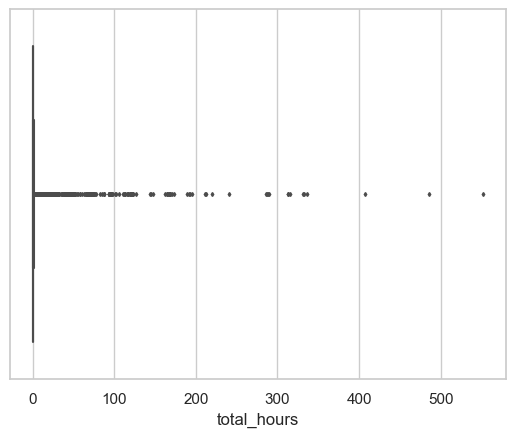

In [ ]:
sns.set_theme(style="whitegrid")
temp = sns.boxplot(x = elapsedTimes["total_hours"], fliersize = 2)

<Axes: xlabel='total_hours', ylabel='Count'>

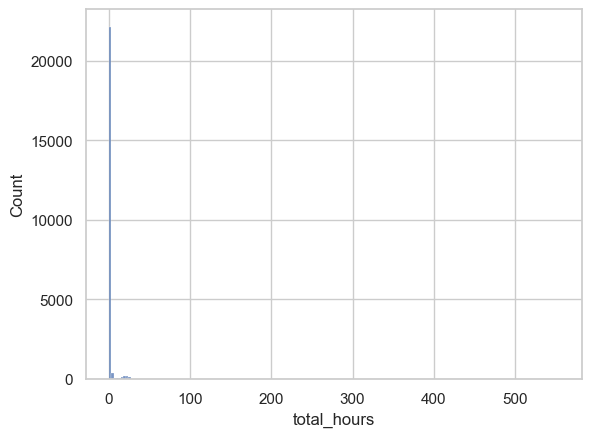

In [ ]:
sns.histplot(x = elapsedTimes["total_hours"], binwidth = 3)

<Axes: xlabel='total_hours', ylabel='Count'>

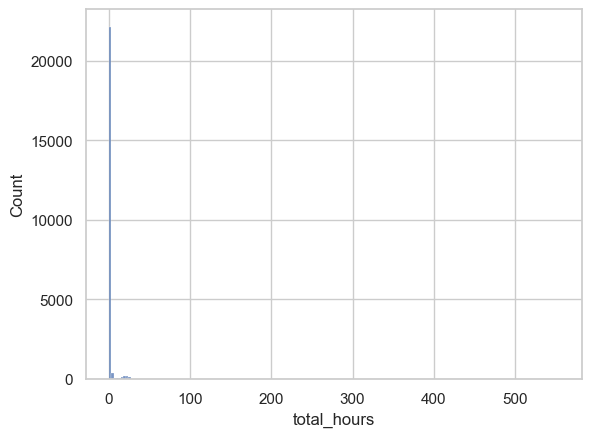

In [ ]:
sns.histplot(x = elapsedTimes["total_hours"], binwidth = 3)

## `checkpoint`

In [ ]:
sessions_to_rem = train.df.filter(col("event_name") == "checkpoint") \
    .groupBy("session_id") \
    .count() \
    .filter(col("count") != 3).cache()
sessions_to_rem.limit(10)

session_id,count
21000508045881390,4
21070307465436760,4
21000416114287984,4
22050515531938264,6
22090409201202380,6
21050214304037116,5
21090110004071096,5
22030506384795480,5
21100309321472060,4
22030410154791324,5


In [ ]:
cleaned_up = cleaned_up.filter(~col("session_id").isin([i.session_id for i in sessions_to_rem.collect()]))

In [ ]:
if False:
    cleaned_up.write.mode("overwrite").parquet(r".\data\df_cleaned_up")

indexes

# Transformação

In [ ]:
splited = train_labels.df \
    .select(
        split("session_id", "_").alias("both"),
        "correct"
    ).select(
        col("both")[0].alias("session_id"),
        col("both")[1].alias("question"),
        col("correct").alias("isCorrect")
    ).cache()
splited.groupby("session_id").count().sort(col("count").asc()).limit(3)

session_id,count
20100209442654932,18
20100216323445964,18
20100308255503228,18


In [ ]:
(pivoted := splited.groupby("session_id").pivot("question").agg(first("isCorrect"))).cache()
pivoted.limit(5)

session_id,q1,q10,q11,q12,q13,q14,q15,q16,q17,q18,q2,q3,q4,q5,q6,q7,q8,q9
20110512573169570,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
20100216323445964,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1
21020308080777748,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0
21040512382351228,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0
22030108542877704,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0


ModuleNotFoundError: No module named 'cairosvg'

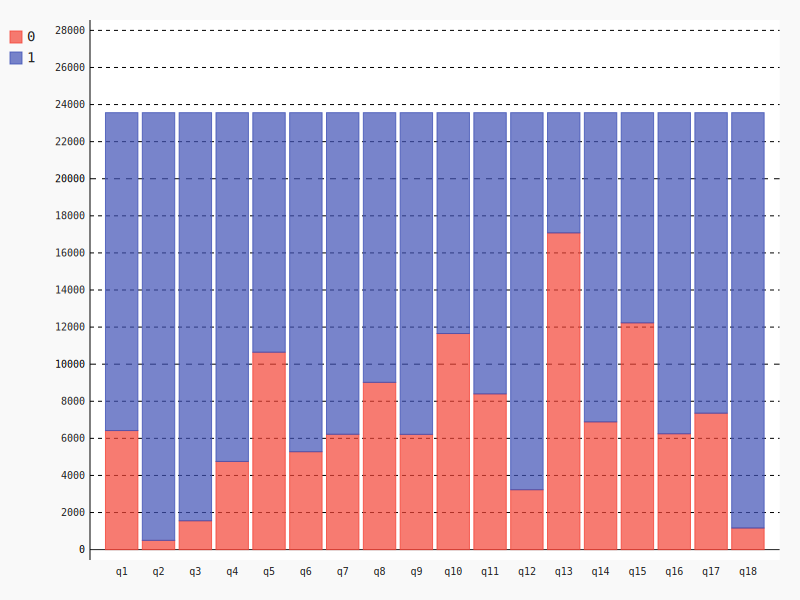

In [ ]:
bar_chart = pygal.StackedBar()
bar_chart.title = ''
bar_chart.x_labels = map(str, [f"q{z}" for z in range(1,19)])
bar_chart.range = [0, 28000]
bar_chart.add('0', [pivoted.select(k).filter(f"{k}==0").count() for k in [f"q{z}" for z in range(1,19)]])
bar_chart.add('1',  [pivoted.select(k).filter(f"{k}==1").count() for k in [f"q{z}" for z in range(1,19)]])
bar_chart

In [ ]:
sessions_to_get = cleaned_up.select("session_id").distinct().sample(fraction=0.01, seed=1).cache()

In [ ]:
amostra = train.df.join(
    sessions_to_get, 
    train.df.session_id == sessions_to_get["session_id"],
    "leftsemi"
).cache()
amostra.limit(5)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20100015580955656,0,0,cutscene_click,basic,0,null,-294.9914052226322,21.68531382977218,null,null,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,1,0,1,0-4
20100015580955656,1,6290,person_click,basic,0,null,-414.99140522263224,86.6853138297722,null,null,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4
20100015580955656,2,12132,person_click,basic,0,null,-393.99140522263224,-149.31468617022782,null,null,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4
20100015580955656,3,14820,person_click,basic,0,null,-393.99140522263224,-149.31468617022782,null,null,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4
20100015580955656,4,16945,person_click,basic,0,null,-382.99140522263224,-150.31468617022782,null,null,null,Meetings are BORING!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4


In [ ]:
if 'stages' in sys.modules: del sys.modules['stages']
from stages import *

pipeline_no_ML = Pipeline(stages = [
    the_transformer(
        add_id,
        (elapsed_to_diff, "elapsed_time", "elapsed_diff_ms"),
        (negative_to_0, "elapsed_diff_ms"),
        (elapsed_to_hours, "elapsed_time", "elapsed_time_h"),
        agg1,
        agg2,
        typeOfText,
    ),
    VectorAssembler(inputCols = ["inv_total_time_h", "inv_total_time_h_0-4", "inv_total_time_h_5-12"], outputCol = "inv_time_to_stand"),
    StandardScaler(inputCol = "inv_time_to_stand", outputCol = "inv_time_standed", withMean = True),
    StringIndexer(inputCol = "type_of_script", outputCol = "index_of_type_of_script"),
    OneHotEncoder(inputCol = "index_of_type_of_script", outputCol="dummies_of_type_of_script"), #sparse vector
])
pipeline_fitted = pipeline_no_ML.fit(amostra)

In [ ]:
(transformed := pipeline_fitted.transform(amostra)).cache()
transformed.limit(1)

session_id,max_index,inv_total_time_h_0-4,inv_total_time_h_5-12,inv_total_time_h,obs_opcional,obs_no_in,notebook_opens,notebook_explorer,fullscreen,hq,music,avg_elapsed_diff_ms_cutscene,avg_elapsed_diff_ms_person,avg_elapsed_diff_ms_navigate,type_of_script,inv_time_to_stand,inv_time_standed,index_of_type_of_script,dummies_of_type_of_script
20100015580955656,856,9.361396720390683,2.6608069784097683,1.2766306030341963,5,1,12,0,1,0,1,2504.8656427286564,2613.4383233965673,4937.380227314577,normal,"[1.2766306030341963,9.361396720390683,2.6608069...","[-0.5985181548513421,-0.7861843022701064,-0.987...",0.0,"(3,[0],[1.0])"


In [ ]:
trans_joined = transformed.join(pivoted, transformed.session_id == pivoted.session_id, "left")
trans_joined.limit(1)

session_id,max_index,inv_total_time_h_0-4,inv_total_time_h_5-12,inv_total_time_h,obs_opcional,obs_no_in,notebook_opens,notebook_explorer,fullscreen,hq,music,avg_elapsed_diff_ms_cutscene,avg_elapsed_diff_ms_person,avg_elapsed_diff_ms_navigate,type_of_script,inv_time_to_stand,inv_time_standed,index_of_type_of_script,dummies_of_type_of_script,session_id,q1,q10,q11,q12,q13,q14,q15,q16,q17,q18,q2,q3,q4,q5,q6,q7,q8,q9
20100015580955656,856,9.361396720390683,2.6608069784097683,1.2766306030341963,5,1,12,0,1,0,1,2504.8656427286564,2613.4383233965673,4937.380227314577,normal,"[1.2766306030341963,9.361396720390683,2.6608069...","[-0.5985181548513421,-0.7861843022701064,-0.987...",0.0,"(3,[0],[1.0])",20100015580955656,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,0,1


In [ ]:
if False:
    sessions_to_get = cleaned_up.select("session_id").distinct().sample(fraction=0.80, seed=1)
    train_to_parquet = train.df.join(
        sessions_to_get, 
        train.df.session_id == sessions_to_get["session_id"],
        "leftsemi"
    )
    test_to_parquet = train.df.join(
        sessions_to_get, 
        train.df.session_id == sessions_to_get["session_id"],
        "leftanti"
    )

    train_to_parquet.write.mode("overwrite").parquet(r".\data\df_train")
    test_to_parquet.write.mode("overwrite").parquet(r".\data\df_test")

In [ ]:
if True:
    trans_all = pipeline_fitted.transform(train.df)
    trans_all.write.mode("overwrite").parquet(r".\data\trans_all")

In [ ]:
all_pandas = trans_all.toPandas()

In [ ]:
times = all_pandas.inv_time_stand_per_group.apply(pd.Series)[0]

AttributeError: 'DataFrame' object has no attribute 'inv_time_stand_per_group'

In [ ]:
from plotnine import *
(
    ggplot(
        times,
        aes(x = times[0], y = after_stat('count'))
    ) + geom_histogram(binwidth=3) + labs(y="count")
)

In [ ]:
if True:
    kakaka ='''
def tempo(xa):
    transformer = pipeline_no_ML.fit(xa)
    trans_train = transformer.transform(xa)
    # pivoted {
    splited = train_labels \
        .select(
            split('session_id', '_').alias('both'),
            'correct'
        ).select(
            col('both')[0].alias('session_id'),
            col('both')[1].alias('question'),
            col('correct').alias('isCorrect')
        );
    pivoted = splited \
    .groupby('session_id') \
    .pivot('question') \
    .agg(first('isCorrect'));
    trans_joined = xa.join(pivoted, ['session_id'], 'left');
    trans_joined.drop(trans_joined.session_id);
    #trans_joined.write.mode("overwrite").parquet(r"data\trans_train")

    trans_test2 = transformer.transform(test);
    trans_test2.drop(trans_test2.session_id);
    #trans_test.write.mode("overwrite").parquet(r"data\trans_test")

    trans_train1 = trans_joined;
    return trans_test2,trans_train1

trans_train2,trans_teste2 = tempo(trans_train)
#trans_train2.count(); trans_teste2.count()
'''
    tempo = tm.Timer(stmt=kakaka, globals=globals())
    result = tempo.repeat(repeat=5,number=1)
    result

NameError: name 'trans_train' is not defined

In [ ]:
trans_train.limit(10)

NameError: name 'trans_train' is not defined